In [47]:
import os

os.environ['DDE_BACKEND'] = 'tensorflow'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import numpy as np
import deepxde as dde

dde.config.set_default_float("float64")
dde.config.set_random_seed(42)
np.random.seed(42)

from deepxde.data import PDE
from deepxde.geometry import TimeDomain
from deepxde.icbc.initial_conditions import IC
from deepxde.icbc import PointSetBC
from deepxde.nn import FNN, PFNN
from deepxde.model import Model
from deepxde.callbacks import VariableValue, EarlyStopping
from deepxde.metrics import mean_squared_error
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
import tensorflow
import pandas as pd

from tensorflow.keras.optimizers.schedules import InverseTimeDecay
from custom_models import AdaptativeDataWeightModel

Set the default float type to float64


In [48]:
df = pd.read_csv("../data/FlunetData_United States of America_All Sites_for_01 August 2023 to 01 August 2024.csv")
df = df.sort_values("Week start date (ISO 8601 calendar)")
df = df[df["Surveillance site type"] == "Non-sentinel"]
df[:5]

,Unnamed: 0,Country area or territory,Surveillance site type,Year-week (ISO 8601 calendar),Week start date (ISO 8601 calendar),Specimen tested,Influenza positive,Influenza negative,A (H1N1)pdm09,A (H3),A (H5),A not subtyped,B (Victoria),B (lineage not determined)
0,1,United States of America,Non-sentinel,2023-32,2023-08-07,35709,307,35402,NaN,NaN,NaN,182,NaN,125
1,2,United States of America,Non-sentinel,2023-33,2023-08-14,39986,355,39631,NaN,NaN,NaN,209,NaN,146
2,3,United States of America,Non-sentinel,2023-34,2023-08-21,44616,364,44252,NaN,NaN,NaN,233,NaN,131
3,4,United States of America,Non-sentinel,2023-35,2023-08-28,53059,381,52678,NaN,NaN,NaN,266,NaN,115
4,5,United States of America,Non-sentinel,2023-36,2023-09-04,55332,388,54944,NaN,NaN,NaN,262,NaN,126


In [49]:

data_I = df["Influenza positive"].to_numpy()
data_I[:10]

array([307, 355, 364, 381, 388, 462, 564, 577, 703, 870])

In [50]:
t0, tf = 0, len(data_I)
gamma = 0.0015
N = 340000000.0 # population size
data_I_norm = data_I / N
S0, I0, R0 = 1.0, data_I_norm[0], 0.0
# data_I_norm = data_I
# S0, I0, R0 = N, data_I_norm[0], 0.0
beta0 = 0.0001

In [51]:
I0

np.float64(9.029411764705883e-07)

In [52]:
data_I.shape

(52,)

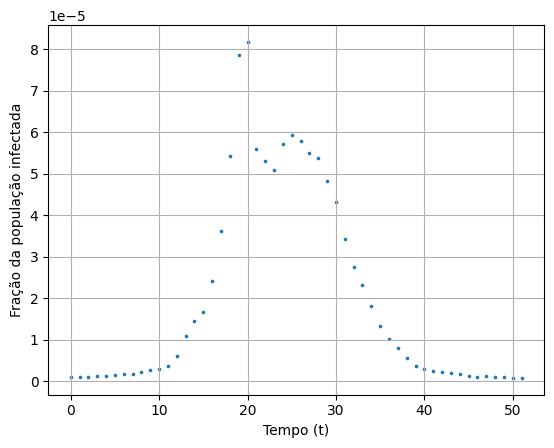

In [53]:
train_t = np.linspace(t0, tf - 1, tf)
# plt.scatter(train_t, data_I, s=2.5)
plt.scatter(train_t, data_I_norm, s=2.5)
plt.xlabel("Tempo (t)")
plt.ylabel("Fração da população infectada")
plt.grid()
plt.show()

In [54]:
train_t

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.])

In [55]:
timeinterval = TimeDomain(t0, tf)

def sir_residual(t, y):
    S, I, beta = y[:,0:1], y[:,1:2], y[:,2:3]

    # S = tensorflow.nn.relu(S)
    # I = tensorflow.nn.relu(I)
    # beta = tensorflow.nn.relu(beta)

    # S = tensorflow.maximum(S, 1.0)
    # I = tensorflow.maximum(I, 1.0)

    dS_dt = dde.gradients.jacobian(y, t, i=0)
    dI_dt = dde.gradients.jacobian(y, t, i=1)
    
    return [
        dS_dt + beta * S * I,
        dI_dt - beta * S * I + gamma * I
    ]

# Tensorflow has an issue with lambdas...
def is_on_initial(_, on_initial): return on_initial
def S0_val(_): return S0
def I0_val(_): return I0
def beta0_val(_): return beta0

ic_S = IC(timeinterval, S0_val, is_on_initial, component=0)
ic_I = IC(timeinterval, I0_val, is_on_initial, component=1)
ic_beta = IC(timeinterval, beta0_val, is_on_initial, component=2)

data_t = train_t.reshape(-1, 1)
data_I_bc = PointSetBC(data_t, data_I_norm, component=1)

ics = [ic_S, ic_I, ic_beta]
data_conds = [
    data_I_bc,
] 

conditions = ics + data_conds

data = PDE(
    timeinterval, 
    sir_residual, 
    conditions,
    num_domain=len(data_I),
    num_boundary=2,
    num_test=len(data_I)//2,
    anchors=data_t
)

n_hidden_layers = 8
hidden_layer_size = 20
topology = [1] + [hidden_layer_size] * n_hidden_layers + [3]
# activation = ["tanh"] * n_hidden_layers + ["sigmoid"]
activation = "tanh"
# activation = "ReLU"
initializer = "Glorot normal"
optimizer = "adam"
lr = 0.002

eq_w = 1
ic1_w = 1
ic2_w = 1
ic3_w = 1
data_w = 10

# loss_weights = [eq_w] * 2 + [ic1_w, ic2_w]
# loss_weights = [eq_w] * 2 + [ic_w] * len(ics) + [data_w] * len(data_conds)

# Com L2
# loss_weights = [eq_w] * 2 + [ic1_w, ic2_w, ic3_w]  + [data_w] * len(data_conds) + [1]

# Sem L2
loss_weights = [eq_w] * 2 + [ic1_w, ic2_w, ic3_w]  + [data_w] * len(data_conds)

net = FNN(
    topology, 
    activation, 
    initializer,
    # regularization=["L2", 1e-5],
    # dropout_rate=0.1,
)

# net = PFNN(
#     topology, 
#     activation, 
#     initializer,
#     # regularization=["L2", 1e-5],
#     # dropout_rate=0,
# )

# def non_zero_hard_constraint(x, y):
#     return tensorflow.nn.relu(y)

# net.apply_output_transform(non_zero_hard_constraint)

# model = AdaptativeDataWeightModel(data, net, n_physics=2 + len(ics), n_data=1)
model = Model(data, net)

model.compile(
    optimizer, 
    lr,
    loss_weights=loss_weights
)


Compiling model...
'compile' took 0.006337 s



In [56]:
len(data_I)//2

26

In [57]:
early_stopping = EarlyStopping(min_delta=1e-12, patience=10000)

adam_iterations = 150000

losshistory, train_state = model.train(
    iterations=adam_iterations, 
    display_every=100,
    callbacks=[
        early_stopping
    ]
)

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [4.05e-02, 1.73e-02, 1.00e+00, 8.15e-13, 1.00e-08, 9.49e-01]    [1.28e-03, 1.37e-03, 1.00e+00, 8.15e-13, 1.00e-08, 9.49e-01]    []  
100       [8.13e-04, 1.02e-05, 1.57e-05, 1.20e-06, 1.58e-07, 1.12e-04]    [4.17e-04, 4.67e-06, 1.57e-05, 1.20e-06, 1.58e-07, 1.12e-04]    []  
200       [2.99e-04, 3.55e-06, 1.89e-07, 4.68e-11, 4.27e-10, 4.74e-05]    [1.59e-04, 2.75e-06, 1.89e-07, 4.68e-11, 4.27e-10, 4.74e-05]    []  
300       [1.01e-04, 2.06e-06, 3.28e-08, 5.03e-08, 4.14e-11, 1.65e-05]    [4.24e-05, 9.74e-07, 3.28e-08, 5.03e-08, 4.14e-11, 1.65e-05]    []  
400       [4.66e-05, 1.92e-06, 6.82e-09, 3.04e-08, 4.57e-12, 5.26e-06]    [1.56e-05, 2.54e-07, 6.82e-09, 3.04e-08, 4.57e-12, 5.26e-06]    []  
500       [2.82e-05, 1.98e-06, 1.85e-09, 1.23e-08, 3.39e-12, 2.61e-06]    [1.04e-05, 9.11e-08, 1.85e-09, 1.23e-08, 3

In [58]:
# model.save("../models/sir-nonoise")
# dde.saveplot(
#     losshistory, 
#     train_state, 
#     issave=True, 
#     isplot=False,
#     output_dir="../losses", 
#     loss_fname=f"loss-sir-nonoise",
#     train_fname=f"train-sir-nonoise",
#     test_fname=f"test-sir-nonoise")

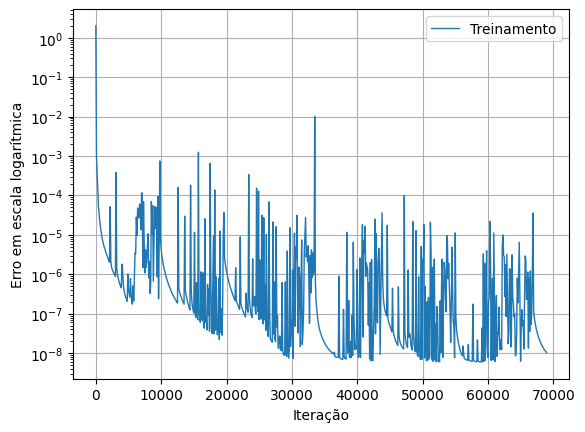

In [59]:
train = np.sum(losshistory.loss_train, axis=1)
plt.semilogy(losshistory.steps, train, "-", label="Treinamento", linewidth=1)
# plt.axhline(y=4.53e-10, color='r', label=r"$Re$ real")
plt.xlabel("Iteração")
plt.ylabel("Erro em escala logarítmica")

plt.legend()
plt.grid()
# plt.savefig(f"../images/sir-loss-nonoise.png")
plt.show()

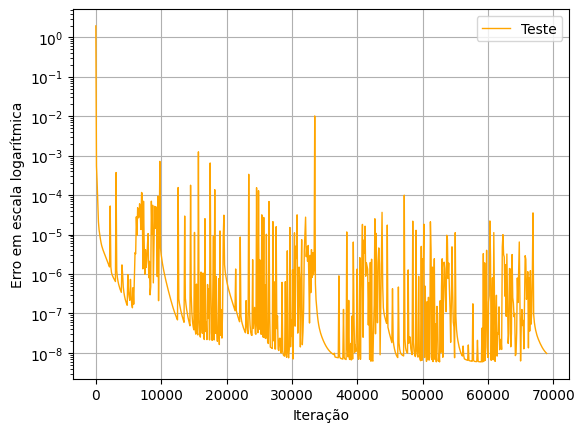

In [60]:
test = np.sum(losshistory.loss_test, axis=1)

plt.semilogy(losshistory.steps, test, "-", label="Teste", color="orange", linewidth=1)

plt.xlabel("Iteração")
plt.ylabel("Erro em escala logarítmica")

plt.legend()
plt.grid()
# plt.savefig(f"../images/sir-loss-nonoise.png")
plt.show()

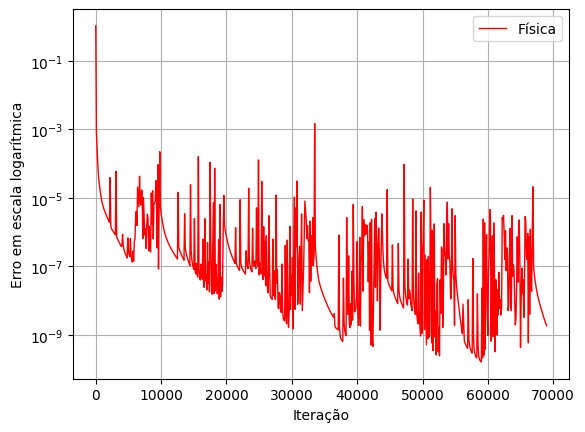

In [61]:
loss_train = np.array(losshistory.loss_train) 

train_phys = np.sum(loss_train[:,:len(ics) + 2], axis=1)
plt.semilogy(losshistory.steps, train_phys, "-", label="Física", color="red", linewidth=1)
plt.xlabel("Iteração")
plt.ylabel("Erro em escala logarítmica")
plt.legend()
plt.grid()
plt.show()

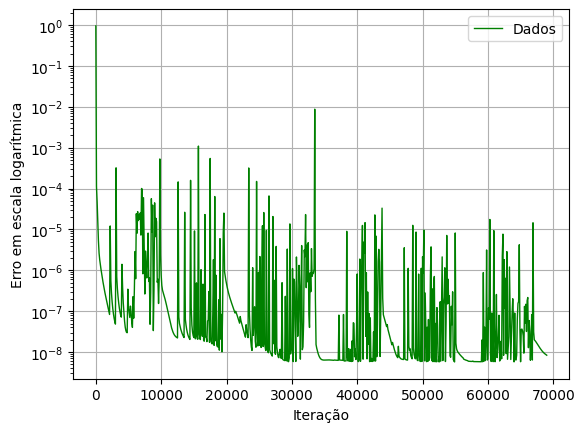

In [62]:
train_data = np.sum(loss_train[:,len(ics) + 2:], axis=1)
plt.semilogy(losshistory.steps, train_data, "-", label="Dados", color="green", linewidth=1)
plt.xlabel("Iteração")
plt.ylabel("Erro em escala logarítmica")
plt.legend()
plt.grid()
plt.show()

In [63]:
# plt.semilogy(np.arange(len(model.data_weight_hist)), model.data_weight_hist)
# plt.show()

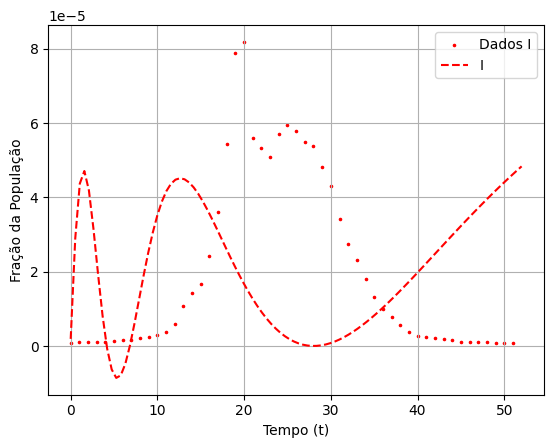

In [64]:
plt.rcParams['text.usetex'] = False
nop_test = 100

test_t = np.linspace(t0, tf, nop_test).reshape(-1, 1)
y_pred = model.predict(test_t)

S_pred = y_pred[:, 0]
I_pred = y_pred[:, 1]

plt.scatter(train_t, data_I_norm, label="Dados I", color="red", s=2.5)
plt.plot(test_t, I_pred, label="I", linestyle="--", color="red")

plt.xlabel("Tempo (t)")
plt.ylabel("Fração da População")

plt.legend()
plt.grid()

plt.show()

In [65]:
y_pred[:, 1]

array([ 1.94394820e-06,  2.89808029e-05,  4.37008045e-05,  4.70818259e-05,
        4.18463092e-05,  3.15097007e-05,  1.94173018e-05,  8.14848046e-06,
       -6.68748560e-07, -6.27114575e-06, -8.55502925e-06, -7.85274945e-06,
       -4.73893872e-06,  1.17539415e-07,  6.05582812e-06,  1.24860250e-05,
        1.89214975e-05,  2.49891899e-05,  3.04254723e-05,  3.50635820e-05,
        3.88171433e-05,  4.16628343e-05,  4.36241047e-05,  4.47569678e-05,
        4.51382725e-05,  4.48564613e-05,  4.40045978e-05,  4.26753324e-05,
        4.09574514e-05,  3.89336659e-05,  3.66793410e-05,  3.42619114e-05,
        3.17407826e-05,  2.91675605e-05,  2.65864890e-05,  2.40350109e-05,
        2.15443875e-05,  1.91403352e-05,  1.68436490e-05,  1.46707959e-05,
        1.26344664e-05,  1.07440791e-05,  9.00623672e-06,  7.42513432e-06,
        6.00292142e-06,  4.74002174e-06,  3.63541360e-06,  2.68687500e-06,
        1.89119676e-06,  1.24436751e-06,  7.41733487e-07,  3.78136327e-07,
        1.48031495e-07,  

[]

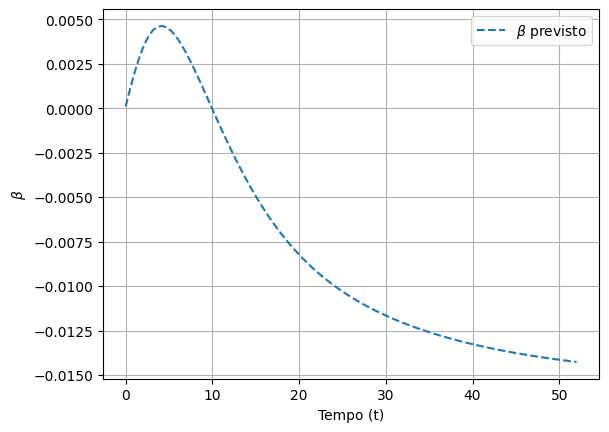

In [66]:
beta_pred = y_pred[:, 2]
plt.plot(test_t, beta_pred, label=r"$\beta$ previsto", linestyle="--")
plt.xlabel("Tempo (t)")
plt.ylabel(r"$\beta$")
plt.legend()
plt.grid()
plt.plot()

In [67]:
beta_pred

array([ 9.99956681e-05,  1.11214947e-03,  2.04308362e-03,  2.85576729e-03,
        3.52476351e-03,  4.03583702e-03,  4.38499912e-03,  4.57687988e-03,
        4.62254272e-03,  4.53715113e-03,  4.33790683e-03,  4.04248219e-03,
        3.66796396e-03,  3.23021350e-03,  2.74352650e-03,  2.22049634e-03,
        1.67201260e-03,  1.10734588e-03,  5.34282734e-04, -4.07165266e-05,
       -6.12356278e-04, -1.17635210e-03, -1.72929128e-03, -2.26850913e-03,
       -2.79198034e-03, -3.29822392e-03, -3.78621952e-03, -4.25533387e-03,
       -4.70525572e-03, -5.13593849e-03, -5.54754998e-03, -5.94042840e-03,
       -6.31504436e-03, -6.67196836e-03, -7.01184315e-03, -7.33536065e-03,
       -7.64324291e-03, -7.93622645e-03, -8.21504987e-03, -8.48044392e-03,
       -8.73312395e-03, -8.97378418e-03, -9.20309349e-03, -9.42169266e-03,
       -9.63019245e-03, -9.82917266e-03, -1.00191818e-02, -1.02007374e-02,
       -1.03743262e-02, -1.05404057e-02, -1.06994046e-02, -1.08517244e-02,
       -1.09977408e-02, -

[]

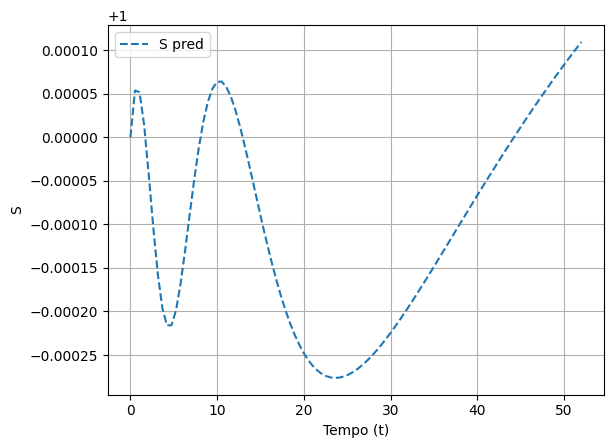

In [68]:
beta_pred = y_pred[:, 0]
plt.plot(test_t, beta_pred, label=r"S pred", linestyle="--")
plt.xlabel("Tempo (t)")
plt.ylabel(r"S")
plt.legend()
plt.grid()
plt.plot()

In [69]:
y_pred[:, 0]

array([0.99999998, 1.00005351, 1.00005151, 1.000014  , 0.9999579 ,
       0.99989718, 0.99984316, 0.999804  , 0.99978409, 0.99978399,
       0.99980124, 0.99983149, 0.99986967, 0.99991094, 0.99995124,
       0.9999875 , 1.00001763, 1.0000405 , 1.00005566, 1.00006324,
       1.00006378, 1.00005808, 1.00004707, 1.00003175, 1.00001313,
       0.99999213, 0.9999696 , 0.99994631, 0.99992287, 0.99989982,
       0.99987758, 0.99985647, 0.99983673, 0.99981853, 0.99980197,
       0.99978711, 0.99977395, 0.99976248, 0.99975265, 0.99974441,
       0.99973768, 0.99973238, 0.99972842, 0.9997257 , 0.99972415,
       0.99972368, 0.99972419, 0.99972561, 0.99972785, 0.99973085,
       0.99973453, 0.99973884, 0.9997437 , 0.99974907, 0.99975489,
       0.99976112, 0.99976771, 0.99977462, 0.99978181, 0.99978925,
       0.99979691, 0.99980476, 0.99981278, 0.99982093, 0.9998292 ,
       0.99983757, 0.99984601, 0.99985452, 0.99986308, 0.99987167,
       0.99988029, 0.99988891, 0.99989753, 0.99990614, 0.99991